In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split, Subset, Sampler, BatchSampler
import h5py
import matplotlib.pyplot as plt
import random
import os
import time
from torch.amp import autocast, GradScaler

# --- configuration ---
PHOTON_FILE = 'photons.hdf5'
ELECTRON_FILE = 'electrons.hdf5'
MODEL_SAVE_PATH = 'electron_photon_resnet15.pth'
OPTIMIZER_SAVE_PATH = MODEL_SAVE_PATH + ".opt"

# -- hyperparameters ---
SEED = 42
BATCH_SIZE = 64       
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 30
NUM_WORKERS = 0
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1
TEST_SPLIT = 0.2

# --- feature flags ---
USE_LOG_TRANSFORM = True
USE_AUGMENTATION = True
USE_MIXED_PRECISION = torch.cuda.is_available()

# --- reproducibility ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- device setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Mixed Precision Training Enabled: {USE_MIXED_PRECISION}")

# --- file checks ---
if not os.path.exists(PHOTON_FILE): raise FileNotFoundError(f"Photon file not found: {PHOTON_FILE}")
if not os.path.exists(ELECTRON_FILE): raise FileNotFoundError(f"Electron file not found: {ELECTRON_FILE}")

Using device: cuda
Mixed Precision Training Enabled: True


In [3]:
with h5py.File(PHOTON_FILE, 'r') as f:
    photon_X_shape = f['X'].shape; photon_y_shape = f['y'].shape
    photon_X_dtype = f['X'].dtype; photon_y_dtype = f['X'].dtype
    photon_y_sample = f['y'][:10]; num_photons = len(f['y'])
    
    print(f"Photon X shape: {photon_X_shape}, dtype: {photon_X_dtype}")
    print(f"Photon y shape: {photon_y_shape}, dtype: {photon_y_dtype}")
    print(f"Photon y sample: {photon_y_sample}")
    print(f"Number of photons: {num_photons}")

with h5py.File(ELECTRON_FILE, 'r') as f:
    electron_X_shape = f['X'].shape; electron_y_shape = f['y'].shape
    electron_X_dtype = f['X'].dtype; electron_y_dtype = f['X'].dtype
    electron_y_sample = f['y'][:10]; num_electrons = len(f['y'])
    
    print(f"Electron X shape: {electron_X_shape}, dtype: {electron_X_dtype}")
    print(f"Electron y shape: {electron_y_shape}, dtype: {electron_y_dtype}")
    print(f"Electron y sample: {electron_y_sample}")
    print(f"Number of electrons: {num_electrons}")

total_samples = num_photons + num_electrons
print(f"Total samples: {total_samples}")
print(f"Class Balance: Photons={num_photons}, Electrons={num_electrons}")

# determined from inspection
PHOTON_LABEL = 0.0
ELECTRON_LABEL = 1.0
print(f"Labels: Photon = {PHOTON_LABEL}, Electron = {ELECTRON_LABEL}")

Photon X shape: (249000, 32, 32, 2), dtype: float32
Photon y shape: (249000,), dtype: float32
Photon y sample: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Number of photons: 249000
Electron X shape: (249000, 32, 32, 2), dtype: float32
Electron y shape: (249000,), dtype: float32
Electron y sample: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of electrons: 249000
Total samples: 498000
Class Balance: Photons=249000, Electrons=249000
Labels: Photon = 0.0, Electron = 1.0


Plotting sample images...


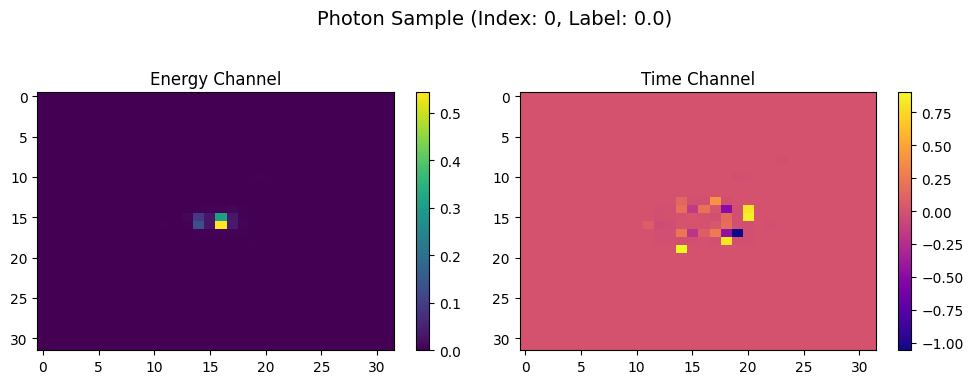

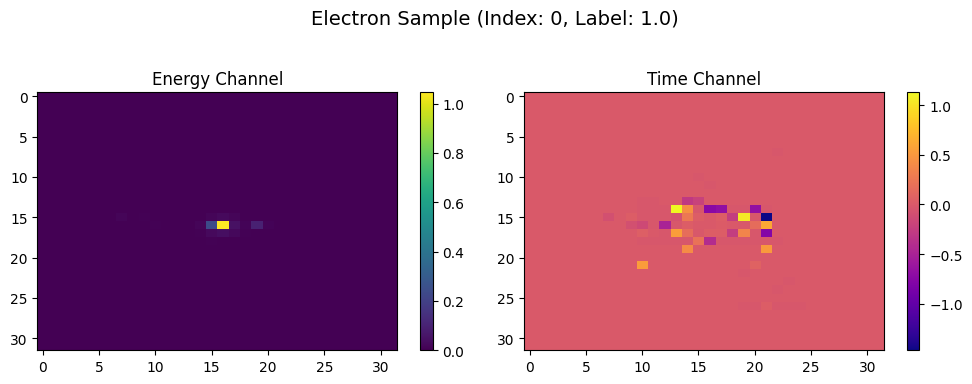


Plotting histograms using 50000 samples per class (GPU processing)...
Histogram data preparation took 140.10 seconds.


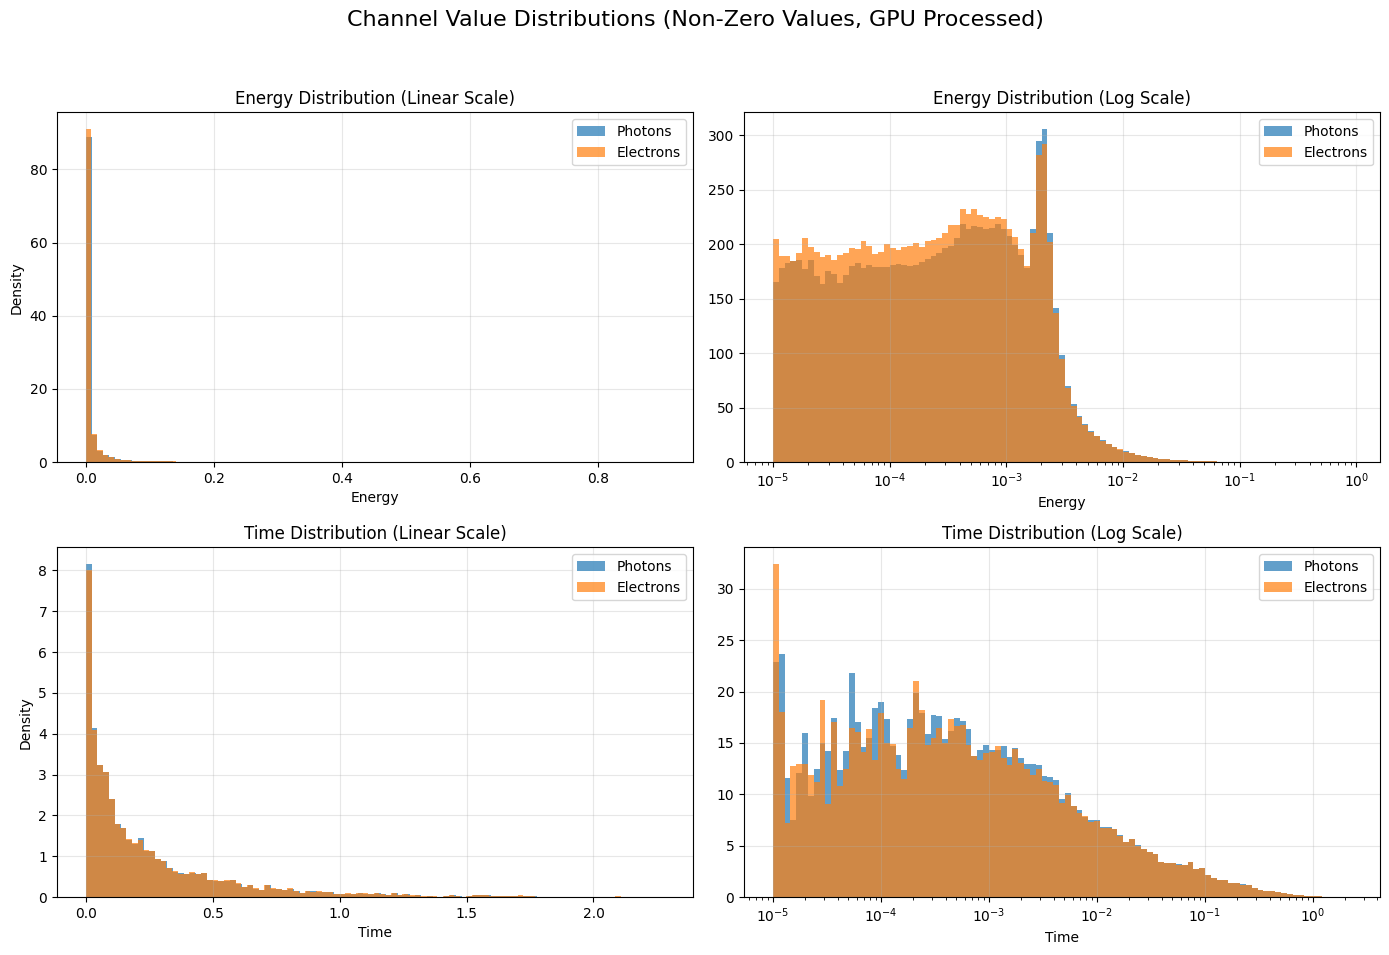

In [4]:
def plot_sample(file_path, index, particle_type_str): # ... (code from analysis3.md cell 4)
    with h5py.File(file_path, 'r') as f: img = f['X'][index]; label_val = f['y'][index]
    energy, time = img[:, :, 0], img[:, :, 1]; fig, axes = plt.subplots(1, 2, figsize=(10, 4)); fig.suptitle(f"{particle_type_str} Sample (Index: {index}, Label: {label_val})", fontsize=14)
    im_energy = axes[0].imshow(energy, cmap='viridis', aspect='auto'); axes[0].set_title('Energy Channel'); fig.colorbar(im_energy, ax=axes[0])
    im_time = axes[1].imshow(time, cmap='plasma', aspect='auto'); axes[1].set_title('Time Channel'); fig.colorbar(im_time, ax=axes[1])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# plot_channel_histograms_gpu function remains the same
def plot_channel_histograms_gpu(num_samples_hist=50000, batch_size_hist=10000): # ... (code from analysis3.md cell 4)
    print(f"\nPlotting histograms using {num_samples_hist} samples per class (GPU processing)..."); start_time = time.time(); # ... (rest of the GPU histogram code)
    photon_indices = np.random.choice(num_photons, num_samples_hist, replace=False); electron_indices = np.random.choice(num_electrons, num_samples_hist, replace=False)
    all_photon_energies_gpu = []; all_photon_times_gpu = []; all_electron_energies_gpu = []; all_electron_times_gpu = []
    with h5py.File(PHOTON_FILE, 'r') as f_p: # Process Photons
        photon_X_ds = f_p['X']
        for i in range(0, num_samples_hist, batch_size_hist): 
            batch_indices = np.sort(photon_indices[i : i + batch_size_hist]) # ... (rest of batch loading and GPU processing)
            if len(batch_indices) == 0: 
                continue
            img_batch_np = photon_X_ds[batch_indices, :, :, :].astype(np.float32)
            img_batch_gpu = torch.from_numpy(img_batch_np).to(device)
            energy_gpu = img_batch_gpu[:, :, :, 0]
            time_gpu = img_batch_gpu[:, :, :, 1]
            if USE_LOG_TRANSFORM: 
                energy_gpu = torch.log1p(energy_gpu)
            all_photon_energies_gpu.append(energy_gpu.flatten())
            all_photon_times_gpu.append(time_gpu.flatten())
            del img_batch_gpu, energy_gpu, time_gpu
            torch.cuda.empty_cache()
    with h5py.File(ELECTRON_FILE, 'r') as f_e: # Process Electrons
        electron_X_ds = f_e['X']
        for i in range(0, num_samples_hist, batch_size_hist): 
            batch_indices = np.sort(electron_indices[i : i + batch_size_hist]) # ... (rest of batch loading and GPU processing)
            if len(batch_indices) == 0: 
                continue
            img_batch_np = electron_X_ds[batch_indices, :, :, :].astype(np.float32)
            img_batch_gpu = torch.from_numpy(img_batch_np).to(device)
            energy_gpu = img_batch_gpu[:, :, :, 0]
            time_gpu = img_batch_gpu[:, :, :, 1]
            if USE_LOG_TRANSFORM: 
                energy_gpu = torch.log1p(energy_gpu)
            all_electron_energies_gpu.append(energy_gpu.flatten())
            all_electron_times_gpu.append(time_gpu.flatten())
            del img_batch_gpu, energy_gpu, time_gpu
            torch.cuda.empty_cache()
    photon_energies = torch.cat(all_photon_energies_gpu).cpu().numpy(); photon_times = torch.cat(all_photon_times_gpu).cpu().numpy(); # ... (rest: concatenate, move to CPU, filter non-zero)
    electron_energies = torch.cat(all_electron_energies_gpu).cpu().numpy(); electron_times = torch.cat(all_electron_times_gpu).cpu().numpy(); del all_photon_energies_gpu, all_photon_times_gpu, all_electron_energies_gpu, all_electron_times_gpu; torch.cuda.empty_cache()
    photon_energies_nz = photon_energies[photon_energies > 1e-6]; electron_energies_nz = electron_energies[electron_energies > 1e-6]; photon_times_nz = photon_times[photon_times > 1e-6]; electron_times_nz = electron_times[electron_times > 1e-6]
    print(f"Histogram data preparation took {time.time() - start_time:.2f} seconds.")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10)); fig.suptitle("Channel Value Distributions (Non-Zero Values, GPU Processed)", fontsize=16); # ... (rest of plotting code)
    axes[0, 0].hist(photon_energies_nz, bins=100, alpha=0.7, label='Photons', density=True); axes[0, 0].hist(electron_energies_nz, bins=100, alpha=0.7, label='Electrons', density=True); #... (rest of axes[0,0] setup)
    axes[0, 0].set_title('Energy Distribution (Linear Scale)'); axes[0, 0].set_xlabel('Energy'); axes[0, 0].set_ylabel('Density'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)
    min_energy = min(photon_energies_nz.min(), electron_energies_nz.min()) if len(photon_energies_nz)>0 and len(electron_energies_nz)>0 else 1e-3; max_energy = max(photon_energies_nz.max(), electron_energies_nz.max()) if len(photon_energies_nz)>0 and len(electron_energies_nz)>0 else 1.0; log_bins_energy = np.logspace(np.log10(max(1e-5, min_energy)), np.log10(max_energy), 100); axes[0, 1].hist(photon_energies_nz, bins=log_bins_energy, alpha=0.7, label='Photons', density=True); axes[0, 1].hist(electron_energies_nz, bins=log_bins_energy, alpha=0.7, label='Electrons', density=True); #... (rest of axes[0,1] setup)
    axes[0, 1].set_title('Energy Distribution (Log Scale)'); axes[0, 1].set_xlabel('Energy'); axes[0, 1].set_xscale('log'); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)
    axes[1, 0].hist(photon_times_nz, bins=100, alpha=0.7, label='Photons', density=True); axes[1, 0].hist(electron_times_nz, bins=100, alpha=0.7, label='Electrons', density=True); #... (rest of axes[1,0] setup)
    axes[1, 0].set_title('Time Distribution (Linear Scale)'); axes[1, 0].set_xlabel('Time'); axes[1, 0].set_ylabel('Density'); axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)
    min_time = min(photon_times_nz.min(), electron_times_nz.min()) if len(photon_times_nz)>0 and len(electron_times_nz)>0 else 1e-3; max_time = max(photon_times_nz.max(), electron_times_nz.max()) if len(photon_times_nz)>0 and len(electron_times_nz)>0 else 1.0; log_bins_time = np.logspace(np.log10(max(1e-5, min_time)), np.log10(max_time), 100); axes[1, 1].hist(photon_times_nz, bins=log_bins_time, alpha=0.7, label='Photons', density=True); axes[1, 1].hist(electron_times_nz, bins=log_bins_time, alpha=0.7, label='Electrons', density=True); #... (rest of axes[1,1] setup)
    axes[1, 1].set_title('Time Distribution (Log Scale)'); axes[1, 1].set_xlabel('Time'); axes[1, 1].set_xscale('log'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- Perform Visualizations ---
print("Plotting sample images..."); plot_sample(PHOTON_FILE, 0, "Photon"); plot_sample(ELECTRON_FILE, 0, "Electron");
plot_channel_histograms_gpu()

In [18]:
def compute_stats_gpu(sample_size=50000, batch_size_stats=10000):
    """Computes mean and std dev using GPU acceleration."""
    print(f"\nComputing normalization stats from {sample_size} samples (GPU processing)...")
    start_time = time.time()
    indices = np.random.choice(total_samples, sample_size, replace=False)

    # Use float64 for accumulators on CPU for precision, then move to GPU if needed
    data_sum_gpu = torch.zeros(2, dtype=torch.float64, device=device)
    data_sum_sq_gpu = torch.zeros(2, dtype=torch.float64, device=device)
    num_pixels = sample_size * 32 * 32

    f_p = h5py.File(PHOTON_FILE, 'r')
    f_e = h5py.File(ELECTRON_FILE, 'r')
    photon_X_ds = f_p['X']
    electron_X_ds = f_e['X']

    processed_count = 0
    for i in range(0, sample_size, batch_size_stats):
        batch_indices_global = indices[i : i + batch_size_stats]
        current_batch_size = len(batch_indices_global)
        if current_batch_size == 0: continue

        photon_mask = batch_indices_global < num_photons
        electron_mask = ~photon_mask
        photon_indices_batch = batch_indices_global[photon_mask]
        electron_indices_batch = batch_indices_global[electron_mask] - num_photons

        batch_data_list = []
        if len(photon_indices_batch) > 0: batch_data_list.append(photon_X_ds[np.sort(photon_indices_batch), :, :, :])
        if len(electron_indices_batch) > 0: batch_data_list.append(electron_X_ds[np.sort(electron_indices_batch), :, :, :])
        if not batch_data_list: continue

        img_batch_np = np.concatenate(batch_data_list, axis=0).astype(np.float32)
        img_batch_gpu = torch.from_numpy(img_batch_np).to(device, dtype=torch.float64) # Use float64 on GPU

        # Apply log transform on GPU if enabled
        if USE_LOG_TRANSFORM:
             # Operate on channels correctly: img_batch_gpu is (B, H, W, C) -> (B, H, W, 0) is energy
             img_batch_gpu[:, :, :, 0] = torch.log1p(img_batch_gpu[:, :, :, 0])

        # Sum over Batch, H, W dimensions. Keep Channel dimension.
        data_sum_gpu += torch.sum(img_batch_gpu, dim=(0, 1, 2))
        data_sum_sq_gpu += torch.sum(img_batch_gpu**2, dim=(0, 1, 2))

        processed_count += current_batch_size
        if processed_count % (10 * batch_size_stats) == 0 or processed_count >= sample_size:
             print(f"  Processed {processed_count}/{sample_size} samples for stats...")
        del img_batch_gpu # Free GPU memory

    f_p.close(); f_e.close()

    mean_gpu = data_sum_gpu / num_pixels
    variance_gpu = (data_sum_sq_gpu / num_pixels) - (mean_gpu**2)
    std_dev_gpu = torch.sqrt(torch.clamp(variance_gpu, min=1e-12)) # Clamp variance before sqrt
    std_dev_gpu = torch.clamp(std_dev_gpu, min=1e-6) # Floor std dev

    # Move stats back to CPU, convert to float32
    mean_cpu = mean_gpu.cpu().numpy().astype(np.float32)
    std_dev_cpu = std_dev_gpu.cpu().numpy().astype(np.float32)

    del data_sum_gpu, data_sum_sq_gpu, mean_gpu, variance_gpu, std_dev_gpu
    torch.cuda.empty_cache()

    print(f"Stats computation took {time.time() - start_time:.2f} seconds.")
    print(f"Computed Mean: {mean_cpu}")
    print(f"Computed Std Dev: {std_dev_cpu}")
    return mean_cpu, std_dev_cpu

GLOBAL_MEAN, GLOBAL_STD = compute_stats_gpu()
GLOBAL_MEAN_GPU = torch.from_numpy(GLOBAL_MEAN).to(device)
GLOBAL_STD_GPU = torch.from_numpy(GLOBAL_STD).to(device)

# --- Custom Batch Sampler for Weak Shuffling ---
class RandomBatchSampler(Sampler):
    """
    Generates batches of sequential indices, then shuffles the batches.
    Yields individual indices for BatchSampler to collect.
    """
    def __init__(self, indices, batch_size):
        self.indices = indices
        self.batch_size = batch_size
        self.num_samples = len(indices)
        self.n_batches = self.num_samples // self.batch_size
        self.batch_ids = torch.randperm(self.n_batches).tolist() # Shuffle batch start indices
        self.last_batch_size = self.num_samples % self.batch_size
        if self.last_batch_size > 0:
            self.n_batches += 1 # Account for the last partial batch

    def __len__(self):
        # This length is technically the number of batches, but __iter__ yields indices
        return self.num_samples

    def __iter__(self):
        for batch_idx in self.batch_ids:
            start = batch_idx * self.batch_size
            end = start + self.batch_size
            # Yield indices from the original list based on shuffled batch order
            for i in range(start, end):
                 yield self.indices[i]

        # Handle the last partial batch if it exists
        if self.last_batch_size > 0 and self.n_batches not in self.batch_ids: # Check if last batch id was already shuffled in
             start = (self.n_batches - 1) * self.batch_size
             end = self.num_samples
             for i in range(start, end):
                  yield self.indices[i]

# --- Modified ParticleDataset ---
class ParticleDataset(Dataset):
    """
    Dataset compatible with BatchSampler.
    __getitem__ receives a LIST of indices for a batch.
    Opens HDF5 file, reads the batch slice/list, returns batch tensors.
    """
    def __init__(self, photon_file, electron_file, num_photons_total):
        # Store paths and total count, NO indices needed here
        self.photon_path = photon_file
        self.electron_path = electron_file
        self.num_photons = num_photons_total
        # File handles will be opened in getitem
        # print(f"Dataset Worker {os.getpid()} initialized.") # Debug

    def __len__(self):
        # The Sampler determines the effective length and indices used
        # This length isn't strictly required by BatchSampler workflow
        # Return total possible samples for reference if needed
        with h5py.File(self.photon_path, 'r') as f_p: n_p = len(f_p['y'])
        with h5py.File(self.electron_path, 'r') as f_e: n_e = len(f_e['y'])
        return n_p + n_e

    def __getitem__(self, index_list):
        """
        Receives a list of global indices for one batch.
        Reads the corresponding data efficiently.
        """
        if not isinstance(index_list, list): # Should receive a list from BatchSampler
             index_list = [index_list] # Handle single index case if necessary

        batch_x_list = []
        batch_y_list = []

        # Separate indices by file for efficient reading
        photon_indices = sorted([idx for idx in index_list if idx < self.num_photons])
        electron_indices = sorted([idx - self.num_photons for idx in index_list if idx >= self.num_photons])

        try:
            # Read photons if any in this batch
            if photon_indices:
                with h5py.File(self.photon_path, 'r') as f:
                    # Read multiple indices efficiently using list indexing
                    x_photons = f['X'][photon_indices, :, :, :].astype(np.float32)
                    batch_x_list.append(x_photons)
                    batch_y_list.extend([PHOTON_LABEL] * len(photon_indices))

            # Read electrons if any in this batch
            if electron_indices:
                 with h5py.File(self.electron_path, 'r') as f:
                     x_electrons = f['X'][electron_indices, :, :, :].astype(np.float32)
                     batch_x_list.append(x_electrons)
                     batch_y_list.extend([ELECTRON_LABEL] * len(electron_indices))

            # Combine data if from both files
            if len(batch_x_list) > 1:
                 batch_x_np = np.concatenate(batch_x_list, axis=0)
                 # Need to re-order according to original index_list to match labels
                 original_order_map = {global_idx: i for i, global_idx in enumerate(index_list)}
                 current_batch_indices = photon_indices + [idx + self.num_photons for idx in electron_indices]
                 sort_indices = np.argsort([original_order_map[global_idx] for global_idx in current_batch_indices])
                 batch_x_np = batch_x_np[sort_indices]
                 batch_y_np = np.array(batch_y_list, dtype=np.float32)[sort_indices]
            elif len(batch_x_list) == 1:
                 batch_x_np = batch_x_list[0]
                 batch_y_np = np.array(batch_y_list, dtype=np.float32)
            else: # Should not happen if index_list is not empty
                 print(f"Warning: Empty batch data for indices {index_list}")
                 return torch.zeros((0, 32, 32, 2), dtype=torch.float32), torch.zeros((0, 1), dtype=torch.float32)


            # Convert final batch to tensors (minimal processing on CPU)
            x_batch_tensor = torch.from_numpy(batch_x_np) # Shape (B, H, W, C)
            y_batch_tensor = torch.from_numpy(batch_y_np).unsqueeze(1) # Shape (B, 1)

            return x_batch_tensor, y_batch_tensor

        except Exception as e:
            print(f"ERROR in worker {os.getpid()} processing batch indices {index_list}: {e}")
            # Return dummy batch of correct expected size if possible
            batch_size = len(index_list)
            return torch.zeros((batch_size, 32, 32, 2), dtype=torch.float32), torch.full((batch_size, 1), -1.0, dtype=torch.float32)


Computing normalization stats from 50000 samples (GPU processing)...
  Processed 50000/50000 samples for stats...
Stats computation took 89.71 seconds.
Computed Mean: [ 0.00102417 -0.0002797 ]
Computed Std Dev: [0.01808323 0.06747373]


In [19]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False); self.bn1 = nn.BatchNorm2d(planes); self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False); self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample; self.stride = stride
    def forward(self, x):
        identity = x; out = self.conv1(x); out = self.bn1(out); out = self.relu(out); out = self.conv2(out); out = self.bn2(out)
        if self.downsample is not None: identity = self.downsample(x)
        out += identity; out = self.relu(out); return out

class ResNet15(nn.Module):
    def __init__(self, block=BasicBlock, layers=[3, 2, 2], num_classes=1, in_channels=2, dropout_prob=0.3):
        super(ResNet15, self).__init__()
        self.in_planes = 64
        # Input: (B, C, H, W) = (B, 2, 32, 32)
        self.conv1 = nn.Conv2d(in_channels, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False) # Output: (B, 64, 32, 32)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        # No MaxPool

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1) # Output: (B, 64, 32, 32)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) # Output: (B, 128, 16, 16)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) # Output: (B, 256, 8, 8)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Output: (B, 256, 1, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(256 * block.expansion, num_classes) # Output: (B, 1)

        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)): nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []; layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks): layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Expects input x: (B, C, H, W)
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        # Return raw logits
        return x

# Instantiate the model
model = ResNet15().to(device)
print(f"Model Architecture:\n{model}")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {total_params:,}"); print(f"Trainable Parameters: {trainable_params:,}")

Model Architecture:
ResNet15(
  (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [20]:
# --- Data Splitting (indices only) ---
indices = np.arange(total_samples); np.random.shuffle(indices)
test_split_idx = int(np.floor(TEST_SPLIT * total_samples)); val_split_idx = int(np.floor((VAL_SPLIT + TEST_SPLIT) * total_samples))
test_indices = indices[:test_split_idx]; val_indices = indices[test_split_idx:val_split_idx]; train_indices = indices[val_split_idx:]
print(f"\nDataset Split Indices:"); print(f"  Training: {len(train_indices)} indices"); print(f"  Validation: {len(val_indices)} indices"); print(f"  Test: {len(test_indices)} indices")

# --- Create Datasets (pass only file paths and num_photons) ---
# The dataset instance itself doesn't need the split indices anymore
full_train_dataset = ParticleDataset(PHOTON_FILE, ELECTRON_FILE, num_photons)
# Use the same dataset instance for val/test, the sampler controls which indices are used
# This avoids creating multiple dataset objects unnecessarily
# However, if augmentations differ, separate instances might be needed. For simplicity now, use one.

# --- Create Samplers ---
train_batch_sampler = BatchSampler(
    RandomBatchSampler(train_indices, BATCH_SIZE), # Custom sampler for weak shuffling
    batch_size=BATCH_SIZE,
    drop_last=True # Drop last incomplete batch during training
)
# For validation/test, use sequential batches (no shuffling)
val_sampler = Subset(full_train_dataset, val_indices) # Use Subset for indices
val_loader = DataLoader(val_sampler, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=device.type=='cuda')

test_sampler = Subset(full_train_dataset, test_indices)
test_loader = DataLoader(test_sampler, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=device.type=='cuda')


def batch_sampler_collate_fn(batch_list):
    """
    Collate function for DataLoader when using BatchSampler.
    It expects batch_list to be a list containing a single tuple
    (the already collated batch from the Dataset's __getitem__).
    """
    if not batch_list:
        # Handle cases where a batch might be empty, though BatchSampler usually avoids this
        return None, None
    # batch_list should contain [(x_batch_tensor, y_batch_tensor)]
    # We just return the inner tuple
    return batch_list[0]

# --- Create Training DataLoader with Batch Sampler ---
pin_memory = device.type == 'cuda'
persist_workers = NUM_WORKERS > 0

train_loader = DataLoader(
    full_train_dataset, # Use the full dataset instance
    batch_sampler=train_batch_sampler, # Use the custom batch sampler
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
    persistent_workers=persist_workers,
    collate_fn=batch_sampler_collate_fn    # batch_size = None, # MUST be None when batch_sampler is specified
    # shuffle = False, # MUST be False when batch_sampler is specified
    # sampler = None, # MUST be None when batch_sampler is specified
    # drop_last = False # Handled by BatchSampler now
)


# For validation and test, we still need standard loaders but using subsets or sequential samplers
# Need to redefine val_loader and test_loader correctly for item-by-item fetching by workers

# Option A: Using Subset - Simpler, relies on default sampler for subset
val_dataset_subset = Subset(full_train_dataset, val_indices)
test_dataset_subset = Subset(full_train_dataset, test_indices)

val_loader = DataLoader(val_dataset_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=persist_workers)
test_loader = DataLoader(test_dataset_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=persist_workers)


print(f"\nDataLoaders created: Train (Batch Sampler), Val/Test (Standard Loader with Subset)")
print(f"Batch Size={BATCH_SIZE}, Num Workers={NUM_WORKERS}, Persistent={persist_workers}")


# --- Loss, Optimizer, Scheduler, Scaler ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)
scaler = GradScaler(enabled=USE_MIXED_PRECISION)

# --- Load Checkpoint Logic ---
# (Same as your analysis3.md cell 7 - checks MODEL_SAVE_PATH, OPTIMIZER_SAVE_PATH)
start_epoch = 0; # ... (rest of checkpoint loading logic)
if os.path.exists(MODEL_SAVE_PATH): # ...
    print(f"\nLoading model weights from {MODEL_SAVE_PATH}..."); # ...
    try: # ...
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device)); print("Model weights loaded.")
        if os.path.exists(OPTIMIZER_SAVE_PATH): # ...
             print(f"Loading optimizer/scheduler state from {OPTIMIZER_SAVE_PATH}..."); # ...
             checkpoint = torch.load(OPTIMIZER_SAVE_PATH, map_location='cpu'); optimizer.load_state_dict(checkpoint['optimizer']); scheduler.load_state_dict(checkpoint['scheduler']); start_epoch = checkpoint.get('epoch', 0) + 1
             print(f"Optimizer and scheduler state loaded. Resuming from epoch {start_epoch}")
        else: print("Optimizer state file not found, initializing optimizer from scratch.")
    except Exception as e: print(f"WARNING: Could not load checkpoint: {e}. Training from scratch."); start_epoch = 0
else: print("\nNo checkpoint found. Starting training from scratch.")


Dataset Split Indices:
  Training: 348600 indices
  Validation: 49800 indices
  Test: 99600 indices

DataLoaders created: Train (Batch Sampler), Val/Test (Standard Loader with Subset)
Batch Size=64, Num Workers=0, Persistent=False

No checkpoint found. Starting training from scratch.


In [ ]:
# preprocess_batch_gpu function remains the same
@torch.no_grad()
def preprocess_batch_gpu(batch_x_raw, mean_gpu, std_gpu, use_log, augment, device):
    # (Code from analysis3.md cell 8 - expects B,H,W,C input)
    batch_x = batch_x_raw.to(device, non_blocking=True)
    batch_x = batch_x.permute(0, 3, 1, 2) # B, C, H, W
    if use_log: 
        batch_x[:, 0, :, :] = torch.log1p(torch.relu(batch_x[:, 0, :, :])) # Log Energy
    mean_reshaped = mean_gpu.view(1, -1, 1, 1)
    std_reshaped = std_gpu.view(1, -1, 1, 1)
    batch_x = (batch_x - mean_reshaped) / std_reshaped # Normalize
    if augment: # Augmentations
        if random.random() < 0.5: noise = torch.randn_like(batch_x) * 0.1; batch_x += noise
    return batch_x

# --- Modified Training/Validation Functions ---
# Note: Loader now yields (batch_x_tensor, batch_y_tensor) directly
def train_one_epoch(model, loader, criterion, optimizer, scaler, device, use_amp, mean_gpu, std_gpu, use_log, use_augment):
    model.train(); total_loss = 0.0; total_correct = 0; total_samples = 0; data_load_time = 0.0; proc_compute_time = 0.0; iter_start_time = time.time()
    # DataLoader with BatchSampler yields the *already collated* batch
    for i, (batch_x_raw, batch_y) in enumerate(loader): # batch_x_raw is (B, H, W, C)
        data_end_time = time.time(); data_load_time += (data_end_time - iter_start_time)
        proc_start_time = time.time()
        batch_x = preprocess_batch_gpu(batch_x_raw, mean_gpu, std_gpu, use_log, use_augment, device) # Preprocess on GPU -> (B, C, H, W)
        batch_y = batch_y.to(device, non_blocking=True) # Move labels
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type=device.type, enabled=use_amp): outputs = model(batch_x); loss = criterion(outputs, batch_y)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        predicted = (torch.sigmoid(outputs) > 0.5).float(); correct = (predicted == batch_y).float().sum().item()
        total_correct += correct; batch_size = batch_y.size(0); total_samples += batch_size; total_loss += loss.item() * batch_size
        proc_end_time = time.time(); proc_compute_time += (proc_end_time - proc_start_time)
        if i % 100 == 0: print(f"  Batch {i:>4}/{len(loader)}, Loss: {loss.item():.4f}, Acc: {correct/batch_size:.4f}, Load: {(data_end_time - iter_start_time)*1000:.1f}ms, Proc: {(proc_end_time - proc_start_time)*1000:.1f}ms")
        iter_start_time = time.time() # Reset timer
    avg_loss=total_loss/total_samples; avg_acc=total_correct/total_samples; avg_data_load_time=data_load_time/len(loader); avg_proc_compute_time=proc_compute_time/len(loader); print(f"  Avg Batch Load Time: {avg_data_load_time*1000:.2f}ms, Avg Batch Proc+Compute Time: {avg_proc_compute_time*1000:.2f}ms")
    return avg_loss, avg_acc

# Validation loader still uses default batching, so __getitem__ is called per item by workers
# We need a different validation function or adjust the loader setup
def validate_one_epoch_std_loader(model, loader, criterion, device, use_amp, mean_gpu, std_gpu, use_log):
    # This function works with standard DataLoaders (like val_loader, test_loader)
    model.eval(); total_loss = 0.0; total_correct = 0; total_samples = 0; val_start_time = time.time()
    with torch.no_grad():
        for batch_x_raw, batch_y in loader: # batch_x_raw is (B, H, W, C) from the Subset loader
             batch_x = preprocess_batch_gpu(batch_x_raw, mean_gpu, std_gpu, use_log, augment=False, device=device) # Preprocess on GPU -> (B, C, H, W)
             batch_y = batch_y.to(device, non_blocking=True)
             with autocast(device_type=device.type, enabled=use_amp): outputs = model(batch_x); loss = criterion(outputs, batch_y)
             predicted = (torch.sigmoid(outputs) > 0.5).float()
             total_correct += (predicted == batch_y).float().sum().item()
             total_samples += batch_y.size(0); total_loss += loss.item() * batch_y.size(0)
    avg_loss=total_loss/total_samples; avg_acc=total_correct/total_samples; print(f"  Validation Time: {time.time() - val_start_time:.2f}s")
    return avg_loss, avg_acc


# --- Training Loop ---
history={'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}; best_val_loss = float('inf')
if start_epoch > 0 and 'best' in scheduler.state_dict(): best_val_loss = scheduler.state_dict()['best'] if scheduler.state_dict()['best'] is not None else float('inf'); print(f"Resuming with best_val_loss = {best_val_loss:.4f}")

print("\n--- Starting Training ---"); epochs_to_run = NUM_EPOCHS - start_epoch
if epochs_to_run <= 0: print("Training already completed.")
else: print(f"Running for {epochs_to_run} epochs (from epoch {start_epoch} to {NUM_EPOCHS-1})")

for epoch in range(start_epoch, NUM_EPOCHS):
    epoch_start_time = time.time(); print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}, Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    # Training uses the batch_sampler loader
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, USE_MIXED_PRECISION, GLOBAL_MEAN_GPU, GLOBAL_STD_GPU, USE_LOG_TRANSFORM, USE_AUGMENTATION)
    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    # Validation uses standard loader with Subset
    val_loss, val_acc = validate_one_epoch_std_loader(model, val_loader, criterion, device, USE_MIXED_PRECISION, GLOBAL_MEAN_GPU, GLOBAL_STD_GPU, USE_LOG_TRANSFORM)
    history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
    epoch_duration = time.time() - epoch_start_time; print("-" * 60); print(f"Epoch {epoch+1} Summary:"); print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}"); print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}"); print(f"  Duration: {epoch_duration:.2f}s"); print("-" * 60)
    scheduler.step(val_loss) # Scheduler Step
    if val_loss < best_val_loss: # Save best model
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model..."); best_val_loss = val_loss; torch.save(model.state_dict(), MODEL_SAVE_PATH); checkpoint = {'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict(), 'epoch': epoch}; torch.save(checkpoint, OPTIMIZER_SAVE_PATH)

print("\n--- Training Finished ---")


--- Starting Training ---
Running for 30 epochs (from epoch 0 to 29)

Epoch 1/30, Current LR: 0.000500
  Batch    0/5446, Loss: 0.6036, Acc: 1.0000, Load: 15992.6ms, Proc: 13.4ms
  Batch  100/5446, Loss: 0.2605, Acc: 1.0000, Load: 15710.2ms, Proc: 11.5ms
  Batch  200/5446, Loss: 0.4791, Acc: 1.0000, Load: 15481.4ms, Proc: 11.5ms
  Batch  300/5446, Loss: 1.0162, Acc: 0.0000, Load: 15793.0ms, Proc: 11.6ms
  Batch  400/5446, Loss: 0.5831, Acc: 1.0000, Load: 15774.2ms, Proc: 11.6ms
  Batch  500/5446, Loss: 0.6798, Acc: 1.0000, Load: 15783.4ms, Proc: 11.4ms
  Batch  600/5446, Loss: 0.9605, Acc: 0.0000, Load: 16272.4ms, Proc: 11.4ms
  Batch  700/5446, Loss: 0.5673, Acc: 1.0000, Load: 15746.7ms, Proc: 11.8ms
  Batch  800/5446, Loss: 0.6961, Acc: 0.0000, Load: 15717.5ms, Proc: 12.1ms
  Batch  900/5446, Loss: 0.6917, Acc: 1.0000, Load: 15714.8ms, Proc: 11.5ms


In [ ]:
# --- Plotting Training History ---
# (Plotting code remains the same - uses 'history' dict)
if history['train_loss']: # ... (rest of plotting code)
    print("\nPlotting training history..."); actual_epochs_run = len(history['train_loss']); # ...
    epochs_range = range(start_epoch + 1, start_epoch + actual_epochs_run + 1); plt.figure(figsize=(14, 5)); #...
    plt.subplot(1, 2, 1); plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='.', linestyle='-'); plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='.', linestyle='-'); plt.xlabel('Epoch'); plt.ylabel('Loss (BCEWithLogitsLoss)'); plt.title('Loss Curves'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2); plt.plot(epochs_range, history['train_acc'], label='Train Accuracy', marker='.', linestyle='-'); plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', marker='.', linestyle='-'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curves'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.savefig('training_curves_v3.png'); plt.show()
else: print("\nNo training history to plot.")

In [ ]:
# --- Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---"); eval_model = ResNet15().to(device)
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Loading best model weights from {MODEL_SAVE_PATH} for evaluation..."); # ... (rest of loading logic)
    try: #...
        eval_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device)); print("Best model weights loaded.")
        test_loss, test_acc = validate_one_epoch_std_loader(eval_model, test_loader, criterion, device, USE_MIXED_PRECISION, GLOBAL_MEAN_GPU, GLOBAL_STD_GPU, USE_LOG_TRANSFORM) # Use correct validation func
        print("-" * 60); print(f"Test Set Performance (using best model):"); print(f"  Test Loss: {test_loss:.4f}"); print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)"); print("-" * 60)
    except Exception as e: print(f"ERROR: Could not load/evaluate saved weights: {e}.")
else: print(f"ERROR: No saved model found at {MODEL_SAVE_PATH}.")